# CS3244 Machine Learning Project
## Dengue case prediction and early warning system
### Data exploration, feature engineering and model training

In [154]:
# Import data processing tools
import pandas as pd
import numpy as np

# Import visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Import utility tools
from math import *
from datetime import datetime

# Import ML tools
# From sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
# From Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint
# From others
from xgboost import XGBRegressor
from xgboost import plot_importance
from imblearn.over_sampling import SMOTE

## Part I: Study whole Singapore data without location clusters

### Data cleaning and feature engineering.

In [72]:
# Load data from csv
raw_data = pd.read_csv("Datasets/Model Training merged data/Singapore Weather PSI and Cases.csv")

# Drop PSI data because of too many NA
raw_data = raw_data.drop(["Avg PSI", "Max PSI"], axis=1)

# Remove rows with NA
raw_data = raw_data.dropna()
raw_data = raw_data.reset_index(drop=True)

# We have missing data in 2019, from Week 6 to Week 13.
# We will split into two subsets, aggregate historical data separately, and then join them back
before_2019 = raw_data["Year"] < 2019
in_2019_before_week_5 = (raw_data["Year"] == 2019) & (raw_data["Week"] <= 5)
data_until_2019_week_5 = raw_data[before_2019 | in_2019_before_week_5]
data_after_2019_week_14 = raw_data[(raw_data["Year"] >= 2019) & (raw_data["Week"] >= 14)]
data_after_2019_week_14 = data_after_2019_week_14.reset_index(drop=True)

In [73]:
data_until_2019_week_5.head(5)

,Year,Week,Max cases with onset in last 2 weeks,Average cases with onset in last 2 weeks,Max Daily Rainfall Total (mm),Min Daily Rainfall Total (mm),Average Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),...,Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Cases in week,population,cases_per_capita,mean_sunshine_hrs,temp_mean_daily_max,mean_relative_humidity
0,2014.0,1.0,155.0,155.000000,57.6,0.0,6.848000,30.6,42.2,52.0,...,32.4,23.3,7.096000,72.4,436.0,5496512.0,0.000079,5.3,29.6,78.5
1,2014.0,2.0,224.0,175.500000,61.8,0.0,7.931429,19.4,24.4,24.8,...,34.0,23.2,6.460000,66.2,479.0,5496512.0,0.000087,5.3,29.6,78.5
2,2014.0,3.0,211.0,202.500000,1.0,0.0,0.028571,1.0,1.0,1.0,...,31.0,23.3,10.185714,45.0,401.0,5496512.0,0.000073,5.3,29.6,78.5
3,2014.0,4.0,168.0,154.500000,0.0,0.0,0.000000,0.0,0.0,0.0,...,31.0,22.4,9.882857,45.4,336.0,5496512.0,0.000061,5.3,29.6,78.5
4,2014.0,5.0,130.0,125.333333,0.0,0.0,0.000000,0.0,0.0,0.0,...,34.3,21.9,10.137143,42.8,234.0,5496512.0,0.000043,8.8,31.9,74.5


To engineer features, we will do the followings:
* Take range of temperature to replace min and max temperature.
* Remove duplicate or very similar features.
* Aggregate N weeks of data starting from 2 weeks ago. For example, if we want to predict the case of Week 10 and N = 4, we want to aggregate data from Week 4 to Week 8.

In [74]:
# feature engineering
def engineer_features(data, N, selected_features, target_col):
    # Replace Max Temperature and Min Temperature with range of temperature
    range_temperature = pd.Series([], dtype='float64')
    for i in range(len(data)):
        range_temperature[i] = data['Maximum Temperature (°C)'][i] - data['Minimum Temperature (°C)'][i]
    data.insert(12, 'Range of Temperature (°C)', range_temperature)
    data = data.drop(['Maximum Temperature (°C)', 'Minimum Temperature (°C)'], axis=1)
    
    # Add aggregated N rows from 2 rows ahead
    for col in selected_features:
        
        # predict 2 weeks
        aggregated_reg = pd.Series([], dtype='float64')
        for i in range(N+2, len(data)):
            aggregate = 0
            for j in range(3, N+3):
                aggregate += data[col][i-j]
            aggregated_reg[i] = aggregate / N
        data.insert(len(data.columns), col + " aggregated for regression", aggregated_reg)
        
        # predict 4 weeks
        aggregated_cls = pd.Series([], dtype='float64')
        for i in range(N+4, len(data)):
            aggregate = 0
            for j in range(5, N+5):
                aggregate += data[col][i-j]
            aggregated_cls[i] = aggregate / N
        data.insert(len(data.columns), col + " aggregated for classification", aggregated_cls)
    
    reg_features = []
    cls_features = []
    for f in selected_features:
        reg_features.append(f + " aggregated for regression")
        cls_features.append(f + " aggregated for classification")
    
    # Drop invalid rows
    data = data.dropna()
    data = data.reset_index(drop=True)
    return data[reg_features + cls_features + target_col]

In [75]:
selected_features = [
                        'Average Daily Rainfall Total (mm)', 
                        'Highest 60 Min Rainfall (mm)', 
                        'Mean Temperature (°C)', 
                        'Range of Temperature (°C)',
                        'Mean Wind Speed (km/h)', 
                        'mean_sunshine_hrs', 
                        'mean_relative_humidity',
                        'Cases in week'
                       ]

target_full = [
    'Max cases with onset in last 2 weeks', 
    'Average cases with onset in last 2 weeks',
]

reg_features = []
cls_features = []
for f in selected_features:
    reg_features.append(f + " aggregated for regression")
    cls_features.append(f + " aggregated for classification")

# Here we set N = 4. Now we are using 4 weeks of historical data to predict for future 2 weeks.
N = 4
data_part_1 = engineer_features(data_until_2019_week_5.copy(), N, selected_features, target_full)
data_part_2 = engineer_features(data_after_2019_week_14.copy(), N, selected_features, target_full)

# Concat two parts and reindex
data_engineered = pd.concat([data_part_1, data_part_2], ignore_index=True)

### Visualization

In [76]:
data_engineered

,Average Daily Rainfall Total (mm) aggregated for regression,Highest 60 Min Rainfall (mm) aggregated for regression,Mean Temperature (°C) aggregated for regression,Range of Temperature (°C) aggregated for regression,Mean Wind Speed (km/h) aggregated for regression,mean_sunshine_hrs aggregated for regression,mean_relative_humidity aggregated for regression,Cases in week aggregated for regression,Average Daily Rainfall Total (mm) aggregated for classification,Highest 60 Min Rainfall (mm) aggregated for classification,Mean Temperature (°C) aggregated for classification,Range of Temperature (°C) aggregated for classification,Mean Wind Speed (km/h) aggregated for classification,mean_sunshine_hrs aggregated for classification,mean_relative_humidity aggregated for classification,Cases in week aggregated for classification,Max cases with onset in last 2 weeks,Average cases with onset in last 2 weeks
0,0.378571,10.300,26.292143,10.325,9.616429,7.050,76.500,311.00,3.702000,16.900,26.321571,9.050,8.406143,5.300,78.500,413.00,91.0,68.333333
1,0.775714,19.250,26.646429,11.525,9.461429,7.925,75.500,303.00,1.990000,6.350,26.240000,9.875,9.166429,6.175,77.500,362.50,67.0,56.250000
2,0.775714,19.250,27.123571,12.350,9.612857,8.800,74.500,267.25,0.378571,10.300,26.292143,10.325,9.616429,7.050,76.500,311.00,107.0,90.666667
3,0.775714,19.250,27.441190,11.975,9.595714,8.600,74.875,255.25,0.775714,19.250,26.646429,11.525,9.461429,7.925,75.500,303.00,157.0,148.000000
4,0.404286,9.200,27.709762,11.850,9.773571,8.400,75.250,239.25,0.775714,19.250,27.123571,12.350,9.612857,8.800,74.500,267.25,193.0,162.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,1.036667,14.525,29.120476,10.200,9.543452,7.375,72.325,513.00,0.929286,12.700,29.117762,10.025,9.206190,7.550,73.650,591.75,329.0,329.000000
270,2.247619,26.900,28.999476,11.300,9.691190,7.150,72.550,445.25,1.019286,15.925,29.240048,10.000,9.417143,7.575,72.875,561.25,299.0,299.000000
271,2.407619,28.275,28.891619,12.100,9.541190,6.925,72.775,393.50,1.036667,14.525,29.120476,10.200,9.543452,7.375,72.325,513.00,218.0,218.000000
272,2.614048,32.650,28.678476,12.525,9.547619,6.700,73.000,337.75,2.247619,26.900,28.999476,11.300,9.691190,7.150,72.550,445.25,204.0,204.000000


Here, we can visual the selected features and possible targets we want to predict.

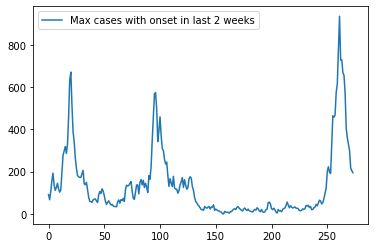

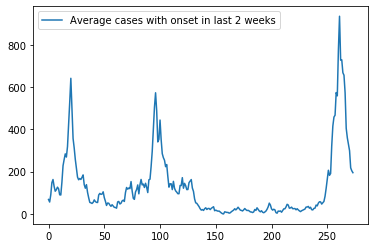

In [77]:
# Trends of cases targets
for target in target_full:
    data_engineered[[target]].plot()

We can observe that two of them are almost the same, and we can take either of them as our target for prediction. Here, we choose _"Average cases with onset in last 2 weeks"_.

Then, to study the correlation between features, we can plot a heatmap:

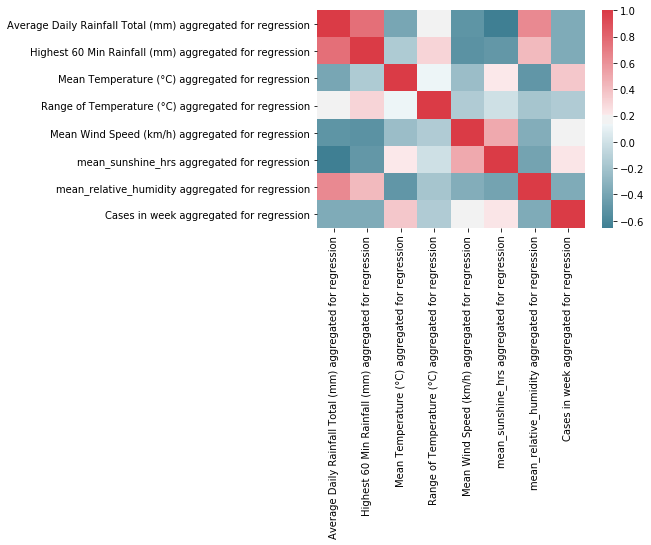

In [78]:
# Correlation between regression features
data_features = data_engineered[reg_features].copy()
corr = data_features.loc[:, data_features.dtypes == 'float64'].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True))

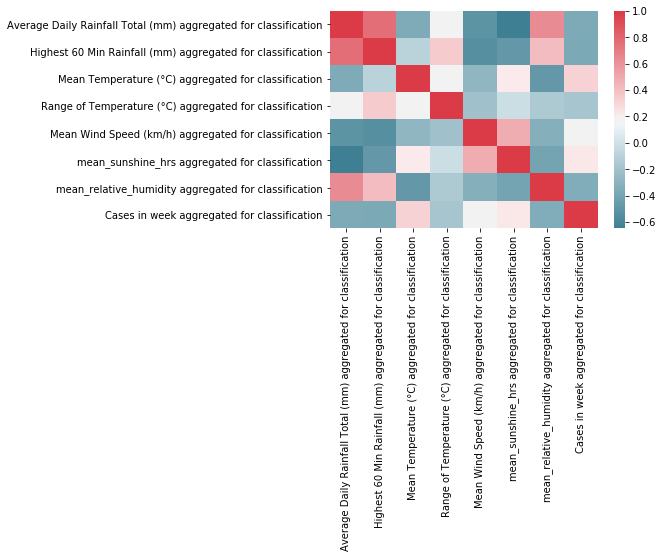

In [79]:
# Correlation between regression features
data_features = data_engineered[cls_features].copy()
corr = data_features.loc[:, data_features.dtypes == 'float64'].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True))

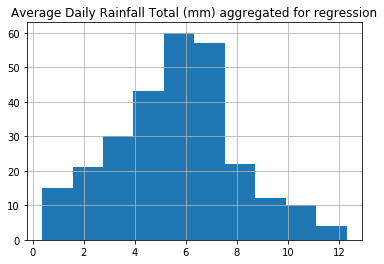

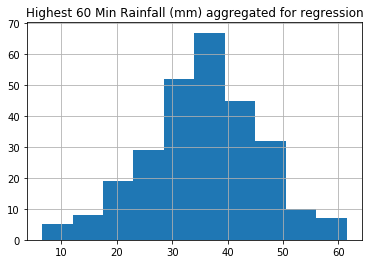

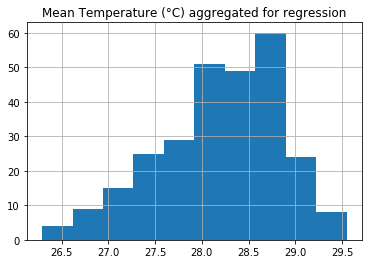

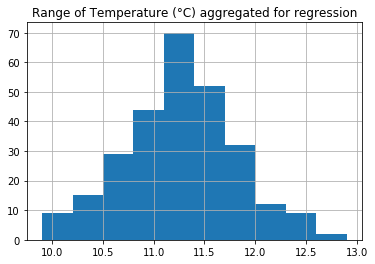

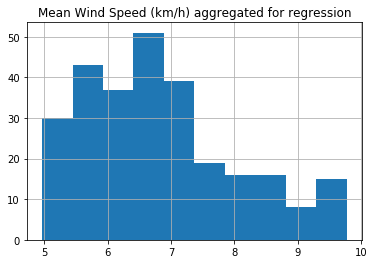

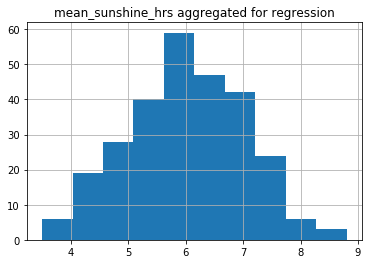

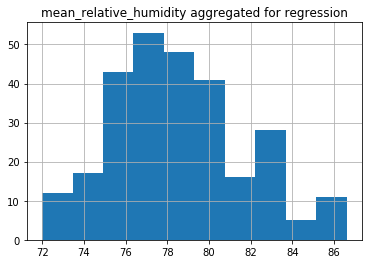

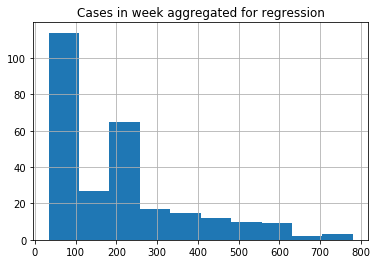

In [80]:
# histograms of regression features
for feature in reg_features:
    data_engineered[[feature]].hist()

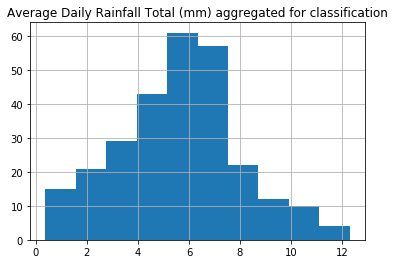

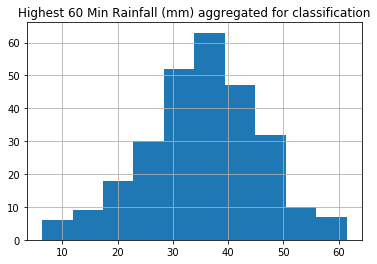

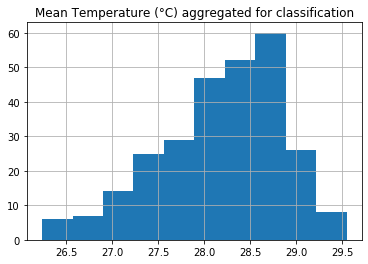

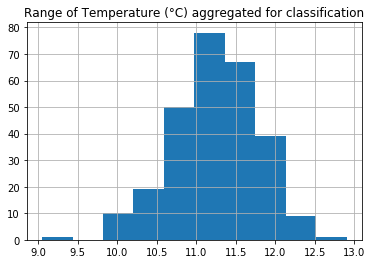

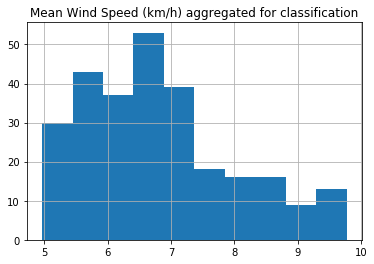

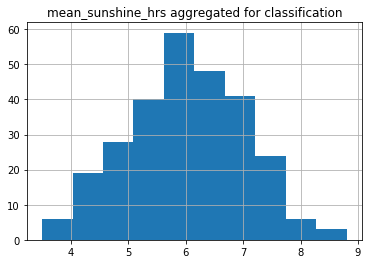

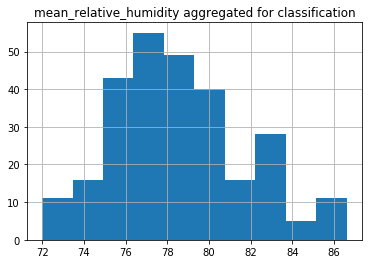

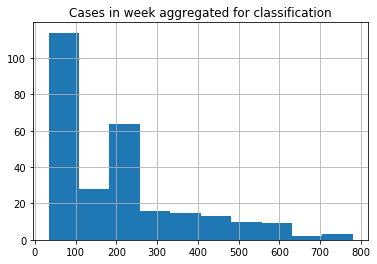

In [81]:
# histograms of classification features
for feature in cls_features:
    data_engineered[[feature]].hist()

We can also see the statistical summary of each column.

In [82]:
data_engineered.describe(percentiles=[0, .2, .4, .6, .8, 1])

,Average Daily Rainfall Total (mm) aggregated for regression,Highest 60 Min Rainfall (mm) aggregated for regression,Mean Temperature (°C) aggregated for regression,Range of Temperature (°C) aggregated for regression,Mean Wind Speed (km/h) aggregated for regression,mean_sunshine_hrs aggregated for regression,mean_relative_humidity aggregated for regression,Cases in week aggregated for regression,Average Daily Rainfall Total (mm) aggregated for classification,Highest 60 Min Rainfall (mm) aggregated for classification,Mean Temperature (°C) aggregated for classification,Range of Temperature (°C) aggregated for classification,Mean Wind Speed (km/h) aggregated for classification,mean_sunshine_hrs aggregated for classification,mean_relative_humidity aggregated for classification,Cases in week aggregated for classification,Max cases with onset in last 2 weeks,Average cases with onset in last 2 weeks
count,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000
mean,5.645262,35.490237,28.187424,11.273175,6.845679,6.012044,78.539964,201.052920,5.650170,35.296077,28.174759,11.255474,6.827674,6.006569,78.560949,201.370438,133.007299,124.853710
std,2.349502,10.358876,0.663009,0.547402,1.196074,1.007743,3.140685,166.325697,2.350129,10.572763,0.683810,0.556009,1.180736,1.006846,3.112010,166.843417,163.025830,158.241402
min,0.378571,6.550000,26.292143,9.900000,4.965714,3.500000,72.000000,33.500000,0.378571,6.350000,26.240000,9.050000,4.965714,3.500000,72.000000,33.500000,0.000000,0.000000
0%,0.378571,6.550000,26.292143,9.900000,4.965714,3.500000,72.000000,33.500000,0.378571,6.350000,26.240000,9.050000,4.965714,3.500000,72.000000,33.500000,0.000000,0.000000
20%,3.648190,27.880000,27.613071,10.825000,5.786038,5.100000,75.715000,57.700000,3.669333,27.140000,27.599743,10.825000,5.786038,5.100000,75.800000,57.700000,22.000000,19.500000
40%,5.170321,33.750000,28.091769,11.150000,6.399988,5.780000,77.505000,99.650000,5.179254,33.150000,28.086571,11.150000,6.399988,5.780000,77.530000,99.650000,45.000000,42.000000
50%,5.788107,35.500000,28.282857,11.275000,6.647173,6.050000,78.375000,172.625000,5.792143,35.500000,28.269750,11.275000,6.626101,6.037500,78.325000,167.750000,67.000000,59.000000
60%,6.255805,38.140000,28.473381,11.400000,6.916168,6.300000,79.000000,220.450000,6.255805,38.070000,28.473381,11.400000,6.895664,6.300000,79.000000,220.450000,113.600000,103.800000
80%,7.412400,44.370000,28.770926,11.710000,7.847143,6.860000,81.360000,304.800000,7.412400,44.370000,28.771350,11.700000,7.813571,6.860000,81.360000,308.900000,190.400000,172.100000


To build an early warning system, we want to classify the average cases within last 2 weeks into 3 categories: green, yellow and red. This is according to the dengue alert color codes from the NEA. Currently, we set the threshold as:
* Greed: 0 - 100
* Yellow: 101 - 200
* Red: above 200

In [83]:
case_bins = [0, 100, 200, 10000]

data_labelled = data_engineered.copy()
for t in target_full:
    data_labelled[t + " labelled"] = pd.cut(data_labelled[t], bins=case_bins, labels=range(3))

l = "Average cases with onset in last 2 weeks labelled"
data_labelled[l] = data_labelled[l].fillna(data_labelled[l].mode()[0])

In [84]:
cleaned_data = data_labelled.copy()
cleaned_data

,Average Daily Rainfall Total (mm) aggregated for regression,Highest 60 Min Rainfall (mm) aggregated for regression,Mean Temperature (°C) aggregated for regression,Range of Temperature (°C) aggregated for regression,Mean Wind Speed (km/h) aggregated for regression,mean_sunshine_hrs aggregated for regression,mean_relative_humidity aggregated for regression,Cases in week aggregated for regression,Average Daily Rainfall Total (mm) aggregated for classification,Highest 60 Min Rainfall (mm) aggregated for classification,Mean Temperature (°C) aggregated for classification,Range of Temperature (°C) aggregated for classification,Mean Wind Speed (km/h) aggregated for classification,mean_sunshine_hrs aggregated for classification,mean_relative_humidity aggregated for classification,Cases in week aggregated for classification,Max cases with onset in last 2 weeks,Average cases with onset in last 2 weeks,Max cases with onset in last 2 weeks labelled,Average cases with onset in last 2 weeks labelled
0,0.378571,10.300,26.292143,10.325,9.616429,7.050,76.500,311.00,3.702000,16.900,26.321571,9.050,8.406143,5.300,78.500,413.00,91.0,68.333333,0,0
1,0.775714,19.250,26.646429,11.525,9.461429,7.925,75.500,303.00,1.990000,6.350,26.240000,9.875,9.166429,6.175,77.500,362.50,67.0,56.250000,0,0
2,0.775714,19.250,27.123571,12.350,9.612857,8.800,74.500,267.25,0.378571,10.300,26.292143,10.325,9.616429,7.050,76.500,311.00,107.0,90.666667,1,0
3,0.775714,19.250,27.441190,11.975,9.595714,8.600,74.875,255.25,0.775714,19.250,26.646429,11.525,9.461429,7.925,75.500,303.00,157.0,148.000000,1,1
4,0.404286,9.200,27.709762,11.850,9.773571,8.400,75.250,239.25,0.775714,19.250,27.123571,12.350,9.612857,8.800,74.500,267.25,193.0,162.666667,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,1.036667,14.525,29.120476,10.200,9.543452,7.375,72.325,513.00,0.929286,12.700,29.117762,10.025,9.206190,7.550,73.650,591.75,329.0,329.000000,2,2
270,2.247619,26.900,28.999476,11.300,9.691190,7.150,72.550,445.25,1.019286,15.925,29.240048,10.000,9.417143,7.575,72.875,561.25,299.0,299.000000,2,2
271,2.407619,28.275,28.891619,12.100,9.541190,6.925,72.775,393.50,1.036667,14.525,29.120476,10.200,9.543452,7.375,72.325,513.00,218.0,218.000000,2,2
272,2.614048,32.650,28.678476,12.525,9.547619,6.700,73.000,337.75,2.247619,26.900,28.999476,11.300,9.691190,7.150,72.550,445.25,204.0,204.000000,2,2


### Model Training


#### Part A: Early warning system by predicting the dengue case level in the next 4 weeks, based on past 4 weeks data (This is essentially a classification problem).

Now, we can start our model training. We do 8-2 split of the entire dataset into train and test sets. We will also perform k-folds on training sets for cross-validation. First, we want to try a few models and get a rough idea what is the best among them.

In [85]:
# Training features
X = cleaned_data[cls_features]

# Take target
y = cleaned_data["Average cases with onset in last 2 weeks labelled"]

# Split into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Then we do oversampling as a mean for data augmentation
oversampler = SMOTE(random_state = 0)
X_train, y_train = oversampler.fit_sample(X_train, y_train)

N_SPLITS = 10
N_FEATURES = len(cls_features)

# Cross-validation
k_fold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=0)

clf = KNeighborsClassifier(n_neighbors = N_FEATURES)
scoring = 'accuracy'
score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print("K Neighbours: {}".format(np.mean(score)*100))

clf = DecisionTreeClassifier(max_depth=round(1.5 * N_FEATURES))
scoring = 'accuracy'
score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print("Decision Tree: {}".format(np.mean(score)*100))

clf = RandomForestClassifier(max_depth=round(1.5 * N_FEATURES))
scoring = 'accuracy'
score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print("Random Forest: {}".format(np.mean(score)*100))

clf = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print("Gaussian Naive Beys: {}".format(np.mean(score)*100))

clf = SVC()
scoring = 'accuracy'
score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print("SVC: {}".format(np.mean(score)*100))

K Neighbours: 80.16042780748663
Decision Tree: 88.89483065953655
Random Forest: 91.89839572192516
Gaussian Naive Beys: 71.43493761140822
SVC: 70.53475935828877


From the experiments above, we can see that Random Forest gives the best score. Thus, we can use this model for classification. Now, we want to tune the parameters to get better performance.

In [164]:
def get_score_RF(n_est, n_features):
    clf = RandomForestClassifier(n_estimators=n_est, max_depth=round(1.5 * n_features))
    scoring = 'accuracy'
    score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
    return np.mean(score)*100

def explore_n_est_RF(estimators, n_features):
    result = {}
    for estimator in estimators:
        result[estimator] = get_score_RF(estimator, n_features)
    plt.plot(list(result.keys()), list(result.values()))
    plt.show()

estimators = range(100, 1000, 100)
explore_n_est_RF(estimators, N_FEATURES)

Now, we can fit the model using best n_estimators from the figure above.

In [87]:
RF = RandomForestClassifier(n_estimators=500)
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [88]:
def plot_feature_importance(X_train, model):
    features_list = X_train.columns.values
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)[:20]

    plt.figure(figsize=(5,7))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
    plt.xlabel('Importance')
    plt.title('Feature importances')
    plt.draw()
    plt.show()

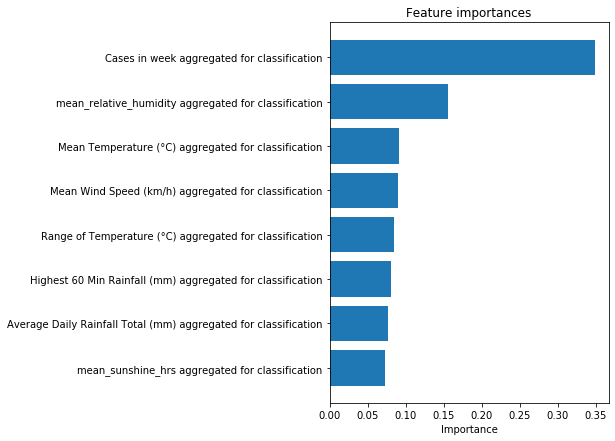

In [89]:
plot_feature_importance(X_train, RF)

Now, we can do predictions on both validation set and test set.

Random Forest Classifier report 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95        49
           1       0.78      0.90      0.84        20
           2       0.93      0.93      0.93        14

    accuracy                           0.92        83
   macro avg       0.90      0.92      0.90        83
weighted avg       0.92      0.92      0.92        83



Text(0.5, 15.0, 'Predicted label')

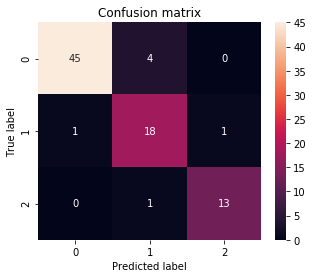

In [90]:
# Predict validation set
y_pred = RF.predict(X_valid)
print("Random Forest Classifier report \n", classification_report(y_valid, y_pred))

# Plot confusion matrix
plt.figure(figsize = (5,4))
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot = True)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

Next, we can use neural network to do classification, and see if we can improve the results.

In [91]:
# define base mode
def model():
    # create model
    model = Sequential()
    model.add(Dense(64, input_dim=N_FEATURES, activation='sigmoid'))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dense(activation='softmax', units=3))
    # Compile model
    model.compile(optimizer = 'adam',loss='categorical_crossentropy', metrics =['accuracy'])
    return model

# use K-folds to test the model
estimator = KerasClassifier(build_fn=model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 79.65% (7.54%)


Neural Network report 
               precision    recall  f1-score   support

           0       0.98      0.86      0.91        49
           1       0.62      0.90      0.73        20
           2       0.91      0.71      0.80        14

    accuracy                           0.84        83
   macro avg       0.84      0.82      0.82        83
weighted avg       0.88      0.84      0.85        83



Text(0.5, 15.0, 'Predicted label')

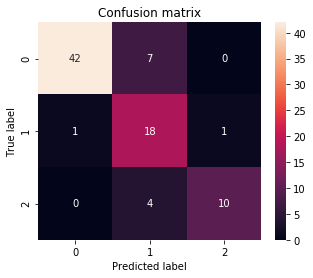

In [92]:
# Fit the model
estimator.fit(X_train, y_train, epochs=200, batch_size=5, verbose=0)
# Predict validation set
y_pred = estimator.predict(X_valid)
print("Neural Network report \n", classification_report(y_valid, y_pred))

# Plot confusion matrix
plt.figure(figsize = (5,4))
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot = True)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#### Part B: Prediction of number of dengue cases in the next 2 weeks, based on past 4 weeks data (This is essentially a regression problem).

Next, we want to do prediction of number of cases. We use regression models for this.

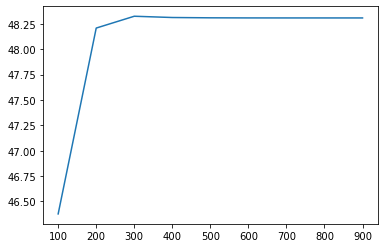

In [93]:
# Training features
X = cleaned_data[reg_features]

# Take target
y = cleaned_data["Average cases with onset in last 2 weeks"]

# Split for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Split for validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

def get_score(n_estimators, learning_rate):
    # Define the model
    model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=0)
    # Fit the model
    model.fit(X_train, y_train)
    # Get predictions
    predictions = model.predict(X_valid)
    # Calculate MAE
    RMSE = sqrt(mean_squared_error(predictions, y_valid))
    return RMSE

# keep constant learning rate
def explore_n_estimators(estimators, learning_rate):
    result = {}
    for estimator in estimators:
        result[estimator] = get_score(estimator, learning_rate)
    plt.plot(list(result.keys()), list(result.values()))
    plt.show()

# explore
estimators = range(100, 1000, 100)
learning_rate = 0.05
explore_n_estimators(estimators, learning_rate)

In [94]:
def get_performance(preds_test, y_test):
    x = range(len(preds_test))
    plt.plot(x, preds_test, label = "predicted")
    plt.plot(x, y_test, label = "ground truth")
    plt.xlabel('x - axis')
    plt.ylabel('y - axis')
    plt.legend()
    plt.show()

    RMSE = sqrt(mean_squared_error(preds_test, y_test))
    MAE = mean_absolute_error(preds_test, y_test)
    print("RMSE: {}\nMAE: {}".format(RMSE, MAE))

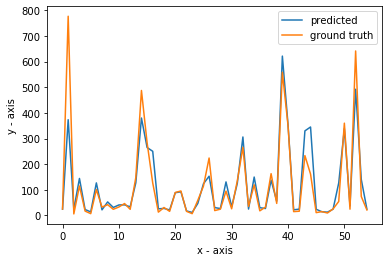

RMSE: 71.76572884158784
MAE: 33.50499545588638


In [95]:
model = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=0)
model.fit(X_train, y_train)
preds_test = model.predict(X_test)
get_performance(preds_test, y_test)

Next, we can use neural network to predict number of cases.

In [41]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal', input_dim = N_FEATURES, activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
NN_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_40 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_41 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_42 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 257       
Total params: 166,017
Trainable params: 166,017
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Training features
X = cleaned_data[reg_features]

# Take target
y = cleaned_data["Average cases with onset in last 2 weeks"]

# Split for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Train
checkpoint_name = 'weights_temp/Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, 
                             save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]
NN_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 175 samples, validate on 44 samples
Epoch 1/200
175/175 [==============================] - 0s 536us/step - loss: 32312.8930 - mean_squared_error: 32312.8906 - val_loss: 44041.8875 - val_mean_squared_error: 44041.8867

Epoch 00001: val_loss improved from inf to 44041.88747, saving model to weights_temp/Weights-001--44041.88747.hdf5
Epoch 2/200
175/175 [==============================] - 0s 46us/step - loss: 16365.3482 - mean_squared_error: 16365.3486 - val_loss: 18764.7184 - val_mean_squared_error: 18764.7188

Epoch 00002: val_loss improved from 44041.88747 to 18764.71835, saving model to weights_temp/Weights-002--18764.71835.hdf5
Epoch 3/200
175/175 [==============================] - 0s 51us/step - loss: 11777.7927 - mean_squared_error: 11777.7930 - val_loss: 17924.7771 - val_mean_squared_error: 17924.7773

Epoch 00003: val_loss improved from 18764.71835 to 17924.77714, saving model to weights_temp/Weights-003--17924.77714.hdf5
Epoch 4/200
175/175 [=============================

175/175 [==============================] - 0s 57us/step - loss: 8029.6722 - mean_squared_error: 8029.6729 - val_loss: 20017.8988 - val_mean_squared_error: 20017.8984

Epoch 00034: val_loss did not improve from 17039.11024
Epoch 35/200
175/175 [==============================] - 0s 51us/step - loss: 7808.1817 - mean_squared_error: 7808.1816 - val_loss: 17503.0663 - val_mean_squared_error: 17503.0664

Epoch 00035: val_loss did not improve from 17039.11024
Epoch 36/200
175/175 [==============================] - 0s 51us/step - loss: 8788.1444 - mean_squared_error: 8788.1445 - val_loss: 17245.6278 - val_mean_squared_error: 17245.6270

Epoch 00036: val_loss did not improve from 17039.11024
Epoch 37/200
175/175 [==============================] - 0s 51us/step - loss: 8345.2149 - mean_squared_error: 8345.2148 - val_loss: 19452.2607 - val_mean_squared_error: 19452.2617

Epoch 00037: val_loss did not improve from 17039.11024
Epoch 38/200
175/175 [==============================] - 0s 51us/step - lo

175/175 [==============================] - 0s 51us/step - loss: 7459.0968 - mean_squared_error: 7459.0962 - val_loss: 17011.7874 - val_mean_squared_error: 17011.7871

Epoch 00069: val_loss improved from 17039.11024 to 17011.78735, saving model to weights_temp/Weights-069--17011.78735.hdf5
Epoch 70/200
175/175 [==============================] - 0s 45us/step - loss: 7787.7423 - mean_squared_error: 7787.7422 - val_loss: 17889.1342 - val_mean_squared_error: 17889.1328

Epoch 00070: val_loss did not improve from 17011.78735
Epoch 71/200
175/175 [==============================] - 0s 51us/step - loss: 7647.1907 - mean_squared_error: 7647.1909 - val_loss: 17519.7476 - val_mean_squared_error: 17519.7480

Epoch 00071: val_loss did not improve from 17011.78735
Epoch 72/200
175/175 [==============================] - 0s 51us/step - loss: 7238.8492 - mean_squared_error: 7238.8491 - val_loss: 18547.0236 - val_mean_squared_error: 18547.0234

Epoch 00072: val_loss did not improve from 17011.78735
Epoch

175/175 [==============================] - 0s 46us/step - loss: 4904.3107 - mean_squared_error: 4904.3105 - val_loss: 14691.4627 - val_mean_squared_error: 14691.4629

Epoch 00135: val_loss improved from 14693.39322 to 14691.46274, saving model to weights_temp/Weights-135--14691.46274.hdf5
Epoch 136/200
175/175 [==============================] - 0s 46us/step - loss: 5088.8528 - mean_squared_error: 5088.8525 - val_loss: 14993.8225 - val_mean_squared_error: 14993.8223

Epoch 00136: val_loss did not improve from 14691.46274
Epoch 137/200
175/175 [==============================] - 0s 51us/step - loss: 4963.4196 - mean_squared_error: 4963.4199 - val_loss: 14389.0328 - val_mean_squared_error: 14389.0322

Epoch 00137: val_loss improved from 14691.46274 to 14389.03276, saving model to weights_temp/Weights-137--14389.03276.hdf5
Epoch 138/200
175/175 [==============================] - 0s 45us/step - loss: 4785.5635 - mean_squared_error: 4785.5635 - val_loss: 16146.9741 - val_mean_squared_error: 1


Epoch 00200: val_loss did not improve from 12582.35158


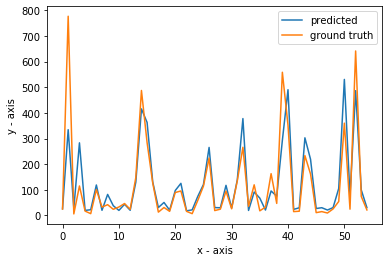

RMSE: 87.68158835375613
MAE: 45.66139448917273


In [35]:
# Load wights file of the best model :
wights_file = 'weights_temp/Weights-184--12772.66566.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

preds_test = NN_model.predict(X_test)
get_performance(preds_test, y_test)

Try Random Forest Regressor also.

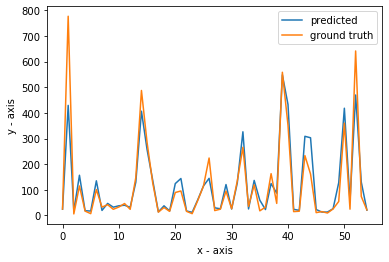

RMSE: 64.21878150435464
MAE: 32.82042424242424


In [96]:
# Training features
X = cleaned_data[reg_features]

# Take target
y = cleaned_data["Average cases with onset in last 2 weeks"]

# Split for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

RF_model = RandomForestRegressor()
RF_model.fit(X_train, y_train)

# Get the mean absolute error on the validation data
preds_test = RF_model.predict(X_test)
get_performance(preds_test, y_test)

## Part II: Study the impact of 5 location clusters.

In [155]:
raw_data_reg = pd.read_csv("Datasets/Model Training merged data/location_cluster_aggregate_2_weeks.csv")
raw_data_cls = pd.read_csv("Datasets/Model Training merged data/location_cluster_aggregate_4_weeks.csv")

# Select features and target
features = [
    "avg_daily_rainfall_total",
    "highest_60_min_rainfall",
    "mean_temperature",
    "range_temperature",
    "mean_wind_speed",
    "historical_cases_week",
    "weather station",
]
target = ["Average cases with onset in last 2 weeks"]
selected_cols = features + target
selected_data_reg = raw_data_reg[selected_cols]
selected_data_cls = raw_data_cls[selected_cols]

# Drop rows with missing data
cleaned_data_reg = selected_data_reg.dropna()
cleaned_data_reg = cleaned_data_reg.reset_index(drop=True)
cleaned_data_cls = selected_data_cls.dropna()
cleaned_data_cls = cleaned_data_cls.reset_index(drop=True)

# Encode categorical features: weather station
le = LabelEncoder()
categorical_cols = ["weather station"]
cleaned_data_reg[categorical_cols] = cleaned_data_reg[categorical_cols].apply(
    lambda col: le.fit_transform(col))
cleaned_data_cls[categorical_cols] = cleaned_data_cls[categorical_cols].apply(
    lambda col: le.fit_transform(col))

In [156]:
cleaned_data_cls

,avg_daily_rainfall_total,highest_60_min_rainfall,mean_temperature,range_temperature,mean_wind_speed,historical_cases_week,weather station,Average cases with onset in last 2 weeks
0,2.627143,4.55,25.850714,7.250,7.630714,80.000000,0,74.000000
1,1.757143,2.35,25.742857,7.700,8.260714,71.722222,0,45.666667
2,0.300000,1.35,25.778571,8.000,8.575000,56.805556,0,32.500000
3,0.300000,1.35,26.171429,8.775,8.325000,53.805556,0,58.000000
4,0.300000,1.35,26.639286,9.175,8.350000,60.250000,0,106.000000
...,...,...,...,...,...,...,...,...
1388,8.507143,24.45,28.067857,8.650,5.400000,11.000000,4,40.000000
1389,7.671429,27.55,28.310714,8.700,5.982143,17.666667,4,23.000000
1390,7.814286,28.70,28.292857,8.700,6.228571,29.666667,4,7.000000
1391,5.642857,26.50,28.207143,8.600,6.189286,41.333333,4,10.000000


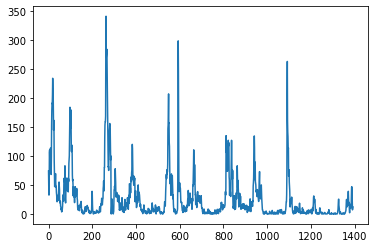

In [157]:
cleaned_data_cls[target[0]].plot()

In [158]:
case_bins = [0, 20, 50, 10000]
labelled_data_cls = cleaned_data_cls.copy()
l = "Average cases with onset in last 2 weeks labelled"
labelled_data_cls[l] = pd.cut(labelled_data_cls[t], bins=case_bins, labels=range(3))
labelled_data_cls[l] = labelled_data_cls[l].fillna(labelled_data_cls[l].mode()[0])

### Part A: Early warning system (classification)

In [159]:
X = labelled_data_cls[features]
y = labelled_data_cls["Average cases with onset in last 2 weeks labelled"]

In [160]:
# Split into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Then we do oversampling as a mean for data augmentation
oversampler = SMOTE(random_state = 0)
X_train, y_train = oversampler.fit_sample(X_train, y_train)

N_SPLITS = 10
N_FEATURES = len(cls_features)

# Cross-validation
k_fold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=0)

clf = KNeighborsClassifier(n_neighbors = N_FEATURES)
scoring = 'accuracy'
score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print("K Neighbours: {}".format(np.mean(score)*100))

clf = DecisionTreeClassifier(max_depth=round(1.5 * N_FEATURES))
scoring = 'accuracy'
score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print("Decision Tree: {}".format(np.mean(score)*100))

clf = RandomForestClassifier(max_depth=round(1.5 * N_FEATURES))
scoring = 'accuracy'
score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print("Random Forest: {}".format(np.mean(score)*100))

clf = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print("Gaussian Naive Beys: {}".format(np.mean(score)*100))

clf = SVC()
scoring = 'accuracy'
score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print("SVC: {}".format(np.mean(score)*100))

K Neighbours: 80.40681961934334
Decision Tree: 81.90903340808464
Random Forest: 88.13840492208614
Gaussian Naive Beys: 69.13719740095452
SVC: 68.81404174573055


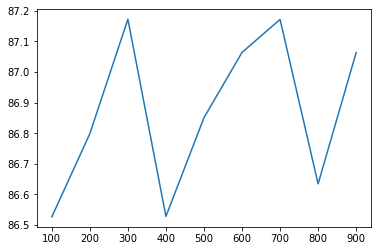

In [166]:
estimators = range(100, 1000, 100)
explore_n_est_RF(estimators, 7)

In [167]:
RF = RandomForestClassifier(n_estimators=300, max_depth=round(1.5 * 7))
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

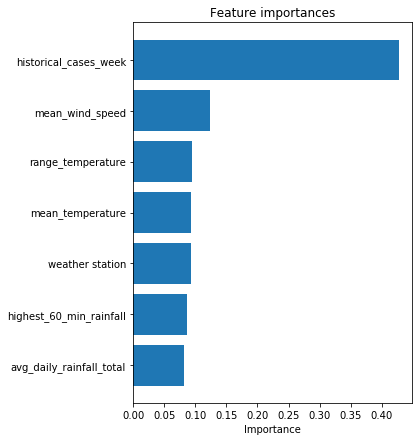

In [168]:
plot_feature_importance(X_train, RF)

Random Forest Classifier report 
               precision    recall  f1-score   support

           0       0.93      0.85      0.89       284
           1       0.49      0.62      0.55        78
           2       0.68      0.73      0.71        56

    accuracy                           0.79       418
   macro avg       0.70      0.73      0.71       418
weighted avg       0.82      0.79      0.80       418



Text(0.5, 15.0, 'Predicted label')

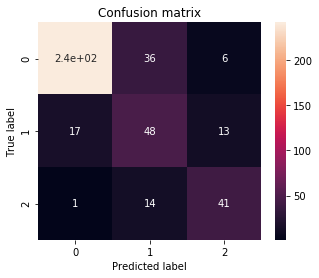

In [169]:
# Predict validation set
y_pred = RF.predict(X_valid)
print("Random Forest Classifier report \n", classification_report(y_valid, y_pred))

# Plot confusion matrix
plt.figure(figsize = (5,4))
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot = True)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [170]:
# define base mode
def model():
    # create model
    model = Sequential()
    model.add(Dense(128, input_dim=7, activation='sigmoid'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dense(activation='softmax', units=3))
    # Compile model
    model.compile(optimizer = 'adam',loss='categorical_crossentropy', metrics =['accuracy'])
    return model

# use K-folds to test the model
estimator = KerasClassifier(build_fn=model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 83.95% (2.46%)


Neural Network report 
               precision    recall  f1-score   support

           0       0.93      0.83      0.88       284
           1       0.43      0.49      0.46        78
           2       0.55      0.75      0.64        56

    accuracy                           0.76       418
   macro avg       0.64      0.69      0.66       418
weighted avg       0.79      0.76      0.77       418



Text(0.5, 15.0, 'Predicted label')

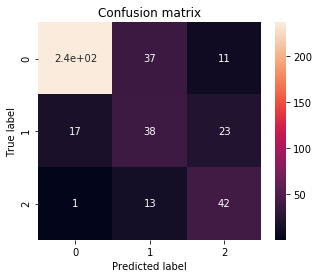

In [171]:
# Fit the model
estimator.fit(X_train, y_train, epochs=200, batch_size=5, verbose=0)
# Predict validation set
y_pred = estimator.predict(X_valid)
print("Neural Network report \n", classification_report(y_valid, y_pred))

# Plot confusion matrix
plt.figure(figsize = (5,4))
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot = True)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Part B: Prediction of number of dengue cases (Regression)

In [133]:
cleaned_data_reg

,avg_daily_rainfall_total,highest_60_min_rainfall,mean_temperature,range_temperature,mean_wind_speed,historical_cases_week,weather station,Average cases with onset in last 2 weeks
0,2.627143,4.55,25.850714,7.250,7.630714,80.000000,0,46.750000
1,1.757143,2.35,25.742857,7.700,8.260714,71.722222,0,60.000000
2,0.300000,1.35,25.778571,8.000,8.575000,56.805556,0,74.000000
3,0.300000,1.35,26.171429,8.775,8.325000,53.805556,0,45.666667
4,0.300000,1.35,26.639286,9.175,8.350000,60.250000,0,32.500000
...,...,...,...,...,...,...,...,...
1407,7.814286,28.70,28.292857,8.700,6.228571,29.666667,4,40.000000
1408,5.642857,26.50,28.207143,8.600,6.189286,41.333333,4,23.000000
1409,6.585714,25.15,28.003571,8.650,5.664286,44.333333,4,7.000000
1410,5.571429,18.55,27.703571,8.625,5.653571,36.666667,4,10.000000


In [144]:
X = cleaned_data_reg[features]
y = cleaned_data_reg[target[0]]

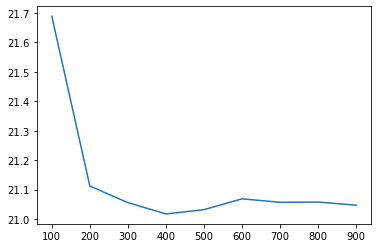

In [145]:
# Split for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Split for validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

# explore
estimators = range(100, 1000, 100)
learning_rate = 0.05
explore_n_estimators(estimators, learning_rate)

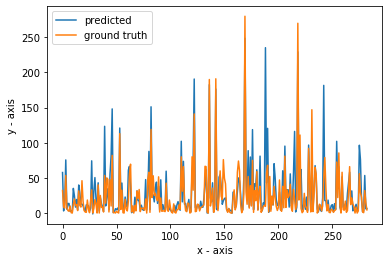

RMSE: 24.700711486317978
MAE: 12.89266970830896


In [146]:
model = XGBRegressor(n_estimators=400, learning_rate=0.05, random_state=0)
model.fit(X_train, y_train)
preds_test = model.predict(X_test)
get_performance(preds_test, y_test)

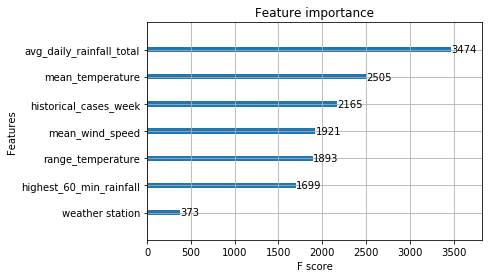

In [147]:
# plot feature importance in the model
plot_importance(model)
plt.show()

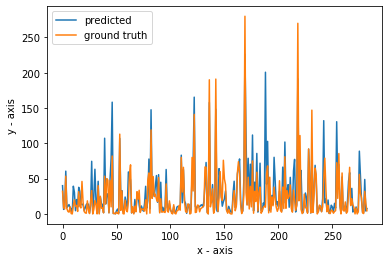

RMSE: 22.64138584937353
MAE: 12.247720848056536


In [148]:
RF_model = RandomForestRegressor()
RF_model.fit(X_train, y_train)

# Get the mean absolute error on the validation data
preds_test = RF_model.predict(X_test)
get_performance(preds_test, y_test)

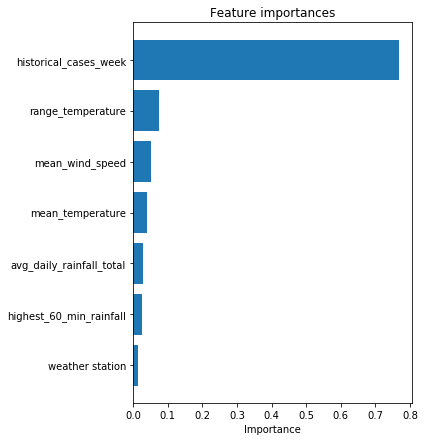

In [149]:
plot_feature_importance(X_train, RF_model)

In [150]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal', input_dim = 7, activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
NN_model.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_150 (Dense)            (None, 128)               1024      
_________________________________________________________________
dense_151 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_152 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_153 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_154 (Dense)            (None, 1)                 257       
Total params: 165,889
Trainable params: 165,889
Non-trainable params: 0
_________________________________________________________________


In [151]:
# Train
checkpoint_name = 'weights_temp/Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, 
                             save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]
NN_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 722 samples, validate on 181 samples
Epoch 1/200
722/722 [==============================] - 0s 163us/step - loss: 1423.6344 - mean_squared_error: 1423.6344 - val_loss: 920.0437 - val_mean_squared_error: 920.0437

Epoch 00001: val_loss improved from inf to 920.04369, saving model to weights_temp/Weights-001--920.04369.hdf5
Epoch 2/200
722/722 [==============================] - 0s 47us/step - loss: 677.8817 - mean_squared_error: 677.8817 - val_loss: 1068.8139 - val_mean_squared_error: 1068.8138

Epoch 00002: val_loss did not improve from 920.04369
Epoch 3/200
722/722 [==============================] - 0s 41us/step - loss: 578.1882 - mean_squared_error: 578.1882 - val_loss: 698.8814 - val_mean_squared_error: 698.8814

Epoch 00003: val_loss improved from 920.04369 to 698.88143, saving model to weights_temp/Weights-003--698.88143.hdf5
Epoch 4/200
722/722 [==============================] - 0s 40us/step - loss: 543.4789 - mean_squared_error: 543.4789 - val_loss: 824.4961 - val_mean_s

722/722 [==============================] - 0s 39us/step - loss: 497.9053 - mean_squared_error: 497.9053 - val_loss: 701.2482 - val_mean_squared_error: 701.2482

Epoch 00035: val_loss did not improve from 685.82470
Epoch 36/200
722/722 [==============================] - 0s 37us/step - loss: 500.1586 - mean_squared_error: 500.1586 - val_loss: 801.5588 - val_mean_squared_error: 801.5589

Epoch 00036: val_loss did not improve from 685.82470
Epoch 37/200
722/722 [==============================] - 0s 36us/step - loss: 492.5671 - mean_squared_error: 492.5671 - val_loss: 879.2478 - val_mean_squared_error: 879.2479

Epoch 00037: val_loss did not improve from 685.82470
Epoch 38/200
722/722 [==============================] - 0s 36us/step - loss: 549.8231 - mean_squared_error: 549.8230 - val_loss: 824.7089 - val_mean_squared_error: 824.7089

Epoch 00038: val_loss did not improve from 685.82470
Epoch 39/200
722/722 [==============================] - 0s 37us/step - loss: 511.7884 - mean_squared_erro

722/722 [==============================] - 0s 37us/step - loss: 467.5229 - mean_squared_error: 467.5229 - val_loss: 730.2818 - val_mean_squared_error: 730.2819

Epoch 00071: val_loss did not improve from 685.82470
Epoch 72/200
722/722 [==============================] - 0s 39us/step - loss: 491.8459 - mean_squared_error: 491.8458 - val_loss: 802.4468 - val_mean_squared_error: 802.4468

Epoch 00072: val_loss did not improve from 685.82470
Epoch 73/200
722/722 [==============================] - 0s 37us/step - loss: 508.3004 - mean_squared_error: 508.3004 - val_loss: 819.5428 - val_mean_squared_error: 819.5428

Epoch 00073: val_loss did not improve from 685.82470
Epoch 74/200
722/722 [==============================] - 0s 39us/step - loss: 505.2693 - mean_squared_error: 505.2693 - val_loss: 737.9032 - val_mean_squared_error: 737.9032

Epoch 00074: val_loss did not improve from 685.82470
Epoch 75/200
722/722 [==============================] - 0s 40us/step - loss: 469.4650 - mean_squared_erro

722/722 [==============================] - 0s 37us/step - loss: 433.2625 - mean_squared_error: 433.2625 - val_loss: 749.1037 - val_mean_squared_error: 749.1037

Epoch 00107: val_loss did not improve from 685.82470
Epoch 108/200
722/722 [==============================] - 0s 38us/step - loss: 438.4429 - mean_squared_error: 438.4430 - val_loss: 807.9524 - val_mean_squared_error: 807.9525

Epoch 00108: val_loss did not improve from 685.82470
Epoch 109/200
722/722 [==============================] - 0s 39us/step - loss: 421.2814 - mean_squared_error: 421.2814 - val_loss: 759.4061 - val_mean_squared_error: 759.4062

Epoch 00109: val_loss did not improve from 685.82470
Epoch 110/200
722/722 [==============================] - 0s 36us/step - loss: 422.4079 - mean_squared_error: 422.4079 - val_loss: 788.2652 - val_mean_squared_error: 788.2652

Epoch 00110: val_loss did not improve from 685.82470
Epoch 111/200
722/722 [==============================] - 0s 37us/step - loss: 425.8043 - mean_squared_

722/722 [==============================] - 0s 40us/step - loss: 435.6132 - mean_squared_error: 435.6131 - val_loss: 784.9526 - val_mean_squared_error: 784.9526

Epoch 00143: val_loss did not improve from 685.82470
Epoch 144/200
722/722 [==============================] - 0s 39us/step - loss: 422.9520 - mean_squared_error: 422.9521 - val_loss: 745.4915 - val_mean_squared_error: 745.4915

Epoch 00144: val_loss did not improve from 685.82470
Epoch 145/200
722/722 [==============================] - 0s 44us/step - loss: 414.8607 - mean_squared_error: 414.8607 - val_loss: 766.2016 - val_mean_squared_error: 766.2016

Epoch 00145: val_loss did not improve from 685.82470
Epoch 146/200
722/722 [==============================] - 0s 41us/step - loss: 406.6612 - mean_squared_error: 406.6611 - val_loss: 764.2532 - val_mean_squared_error: 764.2531

Epoch 00146: val_loss did not improve from 685.82470
Epoch 147/200
722/722 [==============================] - 0s 44us/step - loss: 403.1148 - mean_squared_

722/722 [==============================] - 0s 41us/step - loss: 410.2780 - mean_squared_error: 410.2780 - val_loss: 787.4094 - val_mean_squared_error: 787.4094

Epoch 00179: val_loss did not improve from 685.82470
Epoch 180/200
722/722 [==============================] - 0s 42us/step - loss: 429.3797 - mean_squared_error: 429.3796 - val_loss: 812.3431 - val_mean_squared_error: 812.3433

Epoch 00180: val_loss did not improve from 685.82470
Epoch 181/200
722/722 [==============================] - 0s 44us/step - loss: 399.4104 - mean_squared_error: 399.4105 - val_loss: 736.7236 - val_mean_squared_error: 736.7236

Epoch 00181: val_loss did not improve from 685.82470
Epoch 182/200
722/722 [==============================] - 0s 39us/step - loss: 386.1511 - mean_squared_error: 386.1511 - val_loss: 748.3961 - val_mean_squared_error: 748.3962

Epoch 00182: val_loss did not improve from 685.82470
Epoch 183/200
722/722 [==============================] - 0s 41us/step - loss: 398.2194 - mean_squared_

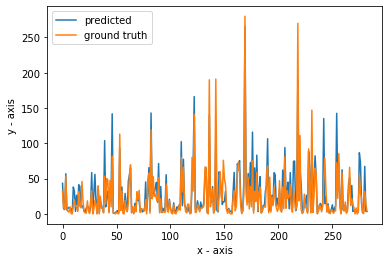

RMSE: 18.893728515001158
MAE: 11.2495205276004


In [152]:
# Load wights file of the best model :
wights_file = 'weights_temp/Weights-016--685.82470.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

preds_test = NN_model.predict(X_test)
get_performance(preds_test, y_test)